In [1]:
#1 Loading libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import json
from tqdm import tqdm
import spacy
import scipy.io
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import spacy
nlp = spacy.load('en_core_web_sm')
import operator
from IPython.core.display import display
from termcolor import colored
from matplotlib.pyplot import figure
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
#2 Loading the json files.
questions = json.load(open('v2_OpenEnded_mscoco_train2014_questions.json', 'r'))
questions = questions['questions']
annotations = json.load(open('v2_mscoco_train2014_annotations.json', 'r'))
annotations = annotations['annotations']

print(len(questions))
print(len(annotations))
print(questions[0])
print(annotations[0])
print(annotations[0].keys())
print(type(annotations[0]))

443757
443757
{'image_id': 458752, 'question': 'What is this photo taken looking through?', 'question_id': 458752000}
{'question_type': 'what is this', 'multiple_choice_answer': 'net', 'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}], 'image_id': 458752, 'answer_type': 'other', 'question_id': 458752000}
dict_keys(['question_type', 'multiple_choice_answer', 'answers', 'image_id', 'answer_type', 

In [7]:
#3 Loading questions and answers files and displaying values
df_questions = pd.DataFrame.from_dict(questions, orient='columns')
df_answers = pd.DataFrame.from_dict(annotations, orient='columns')
df_answers.answers = df_answers.answers.apply(most_freq_ans)
df_questions.name = 'questions'
df_answers.name = 'answers'

In [6]:
#4 Utility functions
def most_freq_ans(answers):
    '''This function returns the most frequent of the 10 answers given annotations'''
    ans_dict = {}
    for a in answers:
        #print(a['answer'])
        ans_dict[a['answer']]=1
    for a in answers:
        ans_dict[a['answer']]+=1
        #print(ans_dict)
    return (max(ans_dict.items(), key = operator.itemgetter(1))[0])

#3 Defining function to explore columns in individual files
def file_details(file):
    """This function explores data types and general info about different fields in the file."""
    print(colored('Sample data from {} file:'.format(file.name),'red',attrs=['bold','reverse','underline']),end='') # Simply print the file df name
    display(file.head(2)) # Display file df head
    
    print(colored('\nDtype of fields:',attrs=['bold']))
    print(file.dtypes) # Data types of the file df
    
    print(colored('\nColumns having Nan values: {}'.format(dict(file.isnull().sum()[file.isnull().sum()>0])),attrs=['bold'])) # Display columns with nan values
    
    dtype = [str(i) for i in np.unique(file.dtypes.values)] # dtypes as list of strings
    if "datetime64[ns]" in dtype:
        print(colored('\nDescription of date fields:',attrs=['bold']))
        print('Min_Date: ',str(file.select_dtypes(['datetime']).min()[0])[:10])
        print('Max_Date: ',str(file.select_dtypes(['datetime']).max()[0])[:10])
    print(colored('\nDescription of numerical columns:',attrs=['bold']),end='')
    display(file.describe(percentiles=[]).apply(lambda s: s.apply('{0:.0f}'.format))) # Describe column properties with float statistics shown without decimals
    if 'object' in dtype:
        print(colored('\nDescription of categorical columns (unique value counts):',attrs=['bold']))
        for cols in file.select_dtypes(['O']).columns:
            print(file[cols].value_counts())
            print()
            
def plot_bar(df):
    '''This function plots bar graph of text counts and the corresponding text given value_counts'''
    plt.figure(figsize=(15,1))
    plt.title(df.name)
    df.plot(kind='bar')
    for i,j in zip(df.index,df):
        plt.annotate(text = round(j),xy=(i,j),ha="right", va="bottom", size="small",color="red",rotation=90)
        plt.plot(i,j,'r*') # marker pointer
    plt.show()
       

def plot_3_most_repeated(df,col):
    most_freq = df[col].value_counts()[:3]
    for i in range(0,3):
        df__ = df[df[col] == most_freq.index[i]]
        if col != 'multiple_choice_answer':
            plt.figure(figsize=(15,3))
            plt.title('Distribution of top 10 answers for {}th most frequent {}'.format(i+1,col))
            plt.plot(df__.multiple_choice_answer.value_counts()[:10])
            plt.show()
        counter = random.sample(range(1, 10), 3)
        plt.figure(figsize=(5*3,5))
        for ind,c in enumerate(counter):
            plt.subplot(1,3,ind+1)
            image_id, answer,question = df__.iloc[c][['image_id_x','multiple_choice_answer','question']].values  
            image = cv2.imread('train2014/train2014/COCO_train2014_000000' + str(image_id).zfill(6) + '.jpg')  
            image = cv2.resize(image, (1050, 900),interpolation = cv2.INTER_NEAREST)
            plt.imshow(image)
            plt.text(-10, -40, question,bbox=dict(facecolor='red', alpha=0.5));
            plt.text(-10, 1020, answer,bbox=dict(facecolor='green', alpha=0.5));
    plt.show()    
    
    
def answer_lies_in_question(df):
    ' This function returns statistics of question-answer pairs where the answer is a subset of the question itself'
    df['s0'] = df.question.str.lower().str.split(" ")
    df['s1'] = df.multiple_choice_answer.str.lower().str.split(" ")
    df['common_word'] = df.apply(lambda x: ' '.join(map(str,sorted(set(x.s0).intersection(set(x.s1))))), axis=1)
    df['answer'] = df.apply(lambda x: ' '.join(map(str,sorted(set(x.s1)))), axis=1)
    df['common_word_is_answer'] = df['common_word'] == df['answer']
    df__ = df[df['common_word_is_answer']==True]
    print('\nNumber of Questions where answer lies in the question:')
    print(df__.shape[0])
    print('\nFrequency of Questions where the answer lies in the question itself:')
    print(df__['question'].value_counts()) 
    print('\nFrequency of Question types where the answer lies in the question itself:')
    print(df__['question_type'].value_counts()) 
    print('\nFrequency of answers where the answer lies in the question itself:')
    print(df__['common_word'].value_counts())  
    print('\nFrequency of answer types where the answer lies in the question itself:')
    print(df__['answer_type'].value_counts())  

# Univariate Analysis

In [38]:
#5 Exploring questions and answers files
file_details(df_questions)
file_details(df_answers)

Sample data from questions file:

image_id                                   question  question_id
0    458752  What is this photo taken looking through?    458752000
1    458752         What position is this man playing?    458752001


Dtype of fields:
image_id        int64
question       object
question_id     int64
dtype: object

Columns having Nan values: {}

Description of numerical columns:

image_id question_id
count   443757      443757
mean    291032   291032032
std     167969   167969402
min          9        9000
50%     292510   292510002
max     581921   581921003


Description of categorical columns (unique value counts):
What room is this?                                          1239
What is the man doing?                                       964
What sport is this?                                          854
What is the man holding?                                     736
What time is it?                                             690
                                                            ... 
Are there people seating?                                      1
What is the setting if there is a phone in the bathroom?       1
Is the temperature below 32 Fahrenheit?                        1
Is the boy outdoors?                                           1
What color are the stripes on the umbrella?                    1
Name: question, Length: 152050, dtype: int64

Sample data from answers file:

question_type multiple_choice_answer  answers  image_id answer_type  \
0  what is this                    net      net    458752       other   
1          what                pitcher  pitcher    458752       other   

   question_id  
0    458752000  
1    458752001


Dtype of fields:
question_type             object
multiple_choice_answer    object
answers                   object
image_id                   int64
answer_type               object
question_id                int64
dtype: object

Columns having Nan values: {}

Description of numerical columns:

image_id question_id
count   443757      443757
mean    291032   291032032
std     167969   167969402
min          9        9000
50%     292510   292510002
max     581921   581921003


Description of categorical columns (unique value counts):
how many             42339
is the               34927
what                 34608
what color is the    27962
what is the          24502
                     ...  
what is the name      1618
what brand            1600
is that a             1585
was                   1551
why is the            1544
Name: question_type, Length: 65, dtype: int64

yes                           84978
no                            82516
1                             12540
2                             12215
white                          8916
                              ...  
off wall                          1
30 91                             1
pregnant                          1
white, green, red and blue        1
one on far left                   1
Name: multiple_choice_answer, Length: 22531, dtype: int64

no                      84572
yes                     82981
2                       12514
1                       12257
white                 

## Observations:
1) Total 152050 unique questions. "What room is this?" repeated 1239 times is the most repeated question followed by "What is the man doing?", "What sport is this?" etc.

2) Total 65 unique question types. "How many" is most frequent question type, followed by "is the" and "what". "Why is the" is the least frequent question and seems to be a reasoning type of question.

3) Total 22531 unique answers. "yes" and "no" are the most frequent answers.

4) Among answer types, there are several "yes/no" type answers. Many answers are also numerical.

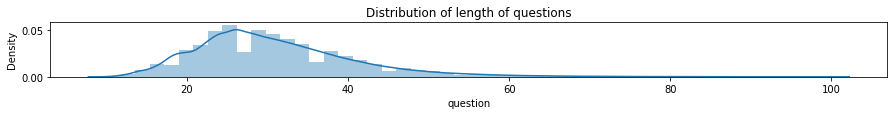

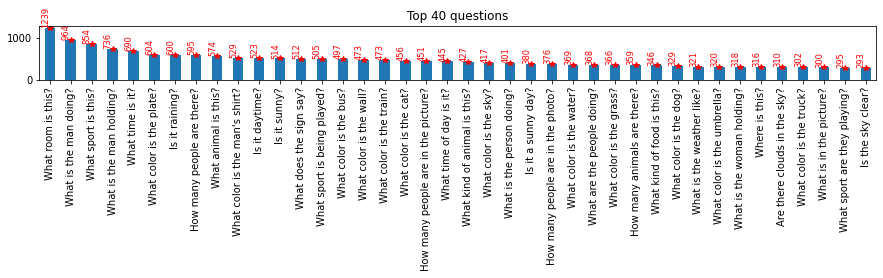

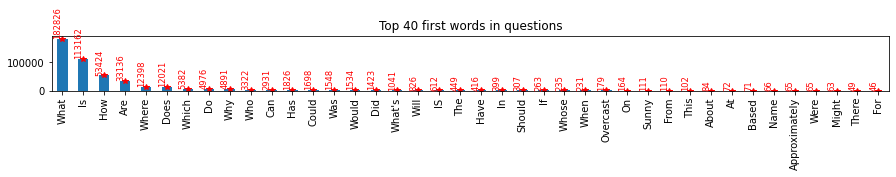

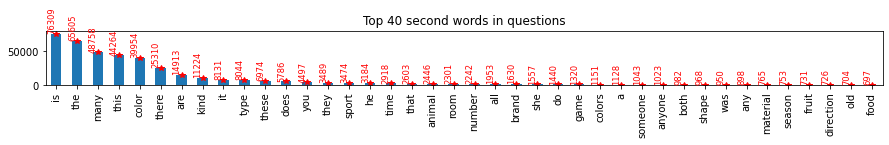

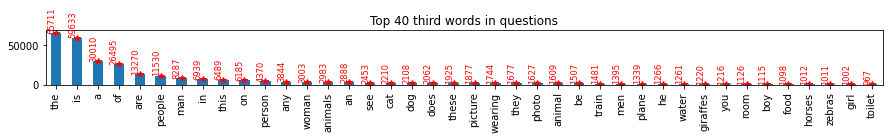

In [127]:
#6 EDA on questions

# Distribution of length of questions
plt.figure(figsize=(15,1))
q_lengths = df_questions.question.str.len() # exploring lengths of questions
plt.title('Distribution of length of questions')
sns.distplot(q_lengths,kde=True)
plt.show()

# Plotting top 40 questions
q_freq = df_questions.question.value_counts()
top_q_freq = q_freq[:40]
top_q_freq.name =  'Top 40 questions'
plot_bar(top_q_freq)

# Plotting top 40 first words in questions
first_word = df_questions.question.str.split().str.get(0) # first word in each question
first_word_freq = first_word.value_counts()
top_first_word_freq_qs = first_word_freq[:40]
top_first_word_freq_qs.name =  'Top 40 first words in questions'
plot_bar(top_first_word_freq_qs)

# Plotting top 40 second words in questions
second_word = df_questions.question.str.split().str.get(1)
second_word_freq = second_word.value_counts()
top_second_word_freq_qs = second_word_freq[:40]
top_second_word_freq_qs.name =  'Top 40 second words in questions'
plot_bar(top_second_word_freq_qs)

# Plotting top 40 third words in questions
third_word = df_questions.question.str.split().str.get(2)
third_word_freq = third_word.value_counts()
top_third_word_freq_qs = third_word_freq[:40]
top_third_word_freq_qs.name =  'Top 40 third words in questions'
plot_bar(top_third_word_freq_qs)


# Observations:
1) Most questions have length between 20 to 40 words

2) Most repeated question is "What room is this?"

3) Most frequent first, second and third words in questions are "What", "is" and "the".

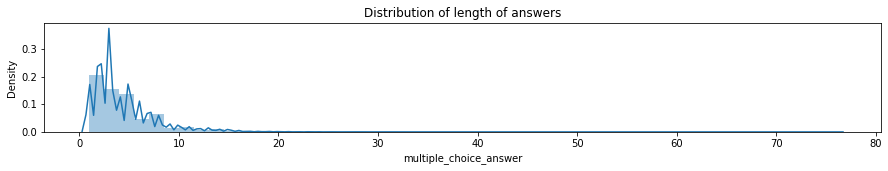

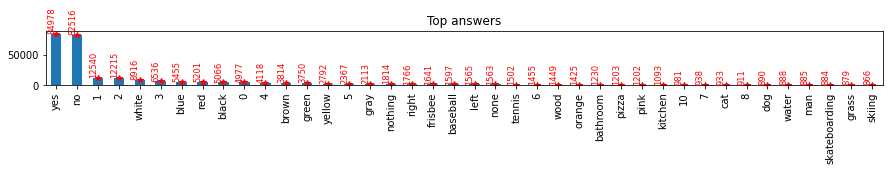

In [128]:
#7 EDA on answers
a_lengths = df_answers.multiple_choice_answer.str.len() # Exploring length of answers
plt.figure(figsize=(15,2))
plt.title('Distribution of length of answers')
sns.distplot(a_lengths,kde=True)
plt.show()

# Plotting top 40 answers
ans_freq = df_answers.multiple_choice_answer.value_counts()
top_ans_freq = ans_freq[:40]
top_ans_freq.name =  'Top answers'
plot_bar(top_ans_freq)

# Bivariate Analysis

In [4]:
#8 Merging question and answer dataframes
df_ = pd.merge(df_questions,df_answers.drop(['answers'],axis=1),how='left',on = 'question_id')

In [5]:
df_.to_csv('question_answer.csv')


3 most frequent questions:


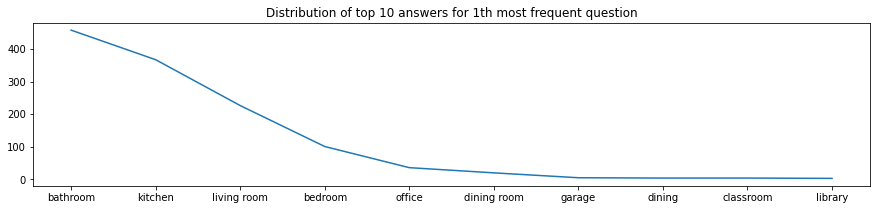

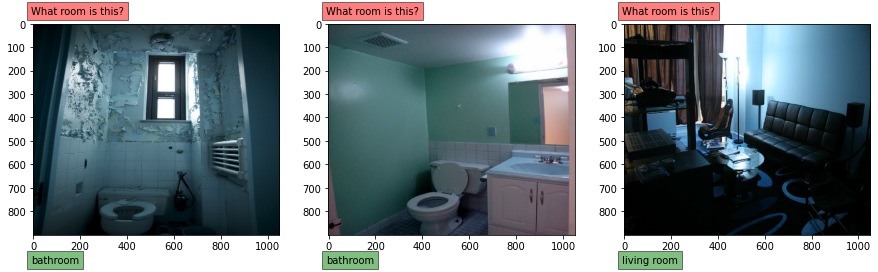

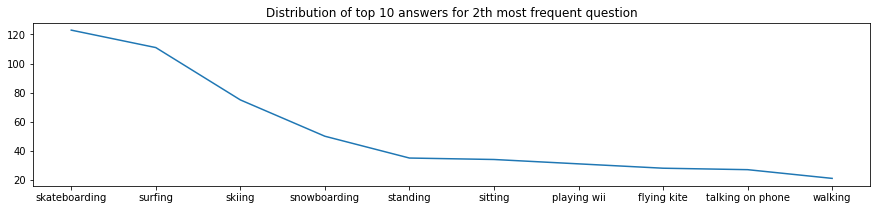

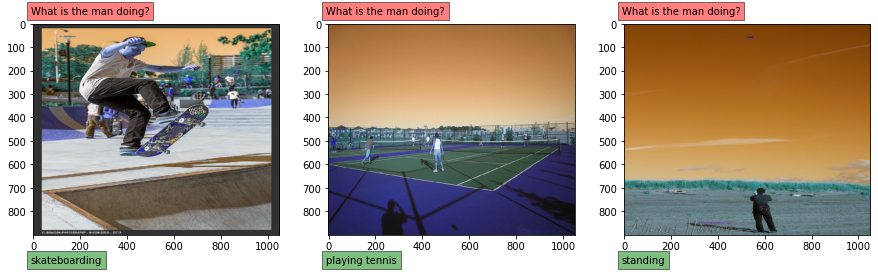

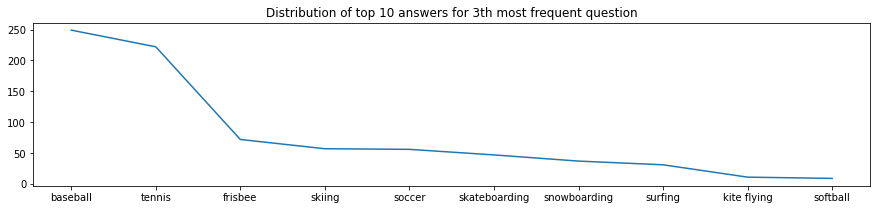

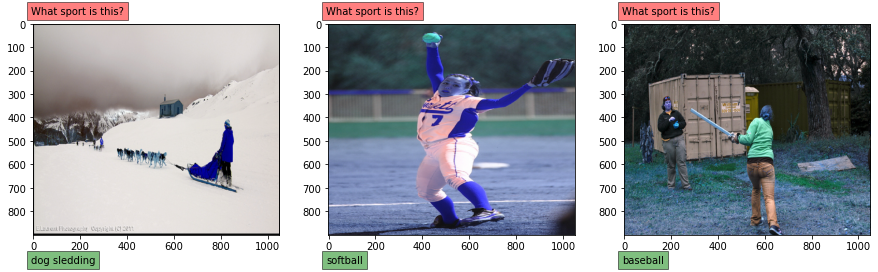


3 most frequent question types:


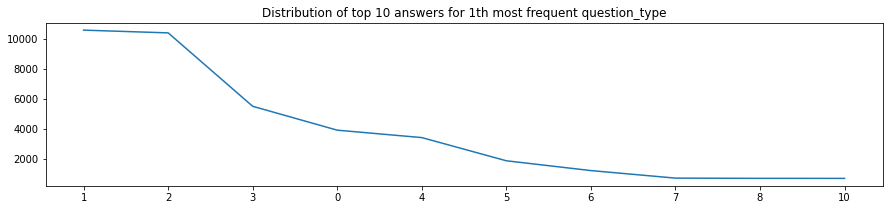

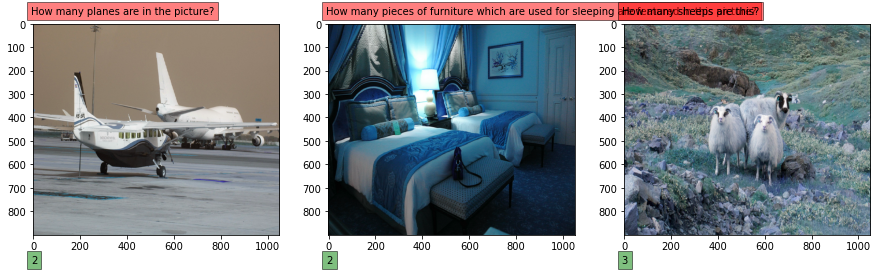

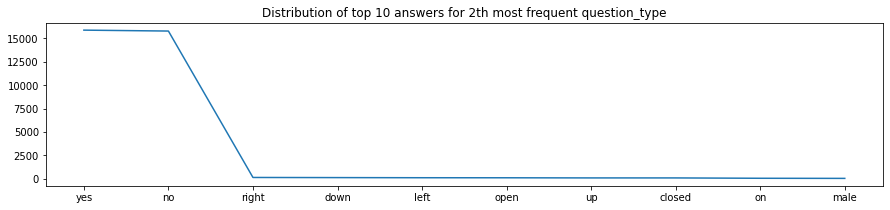

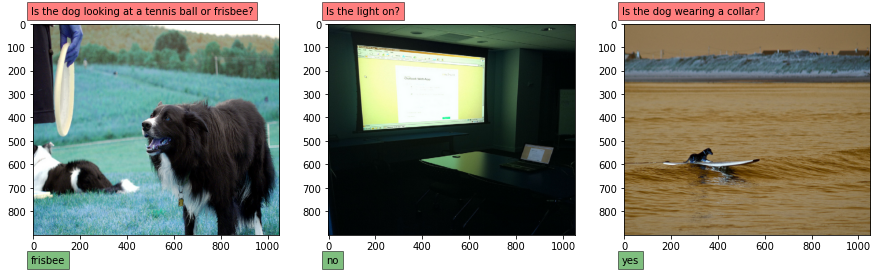

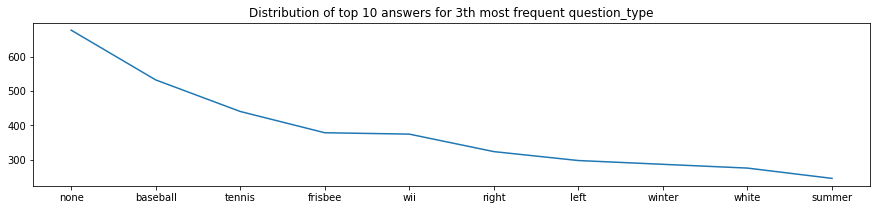

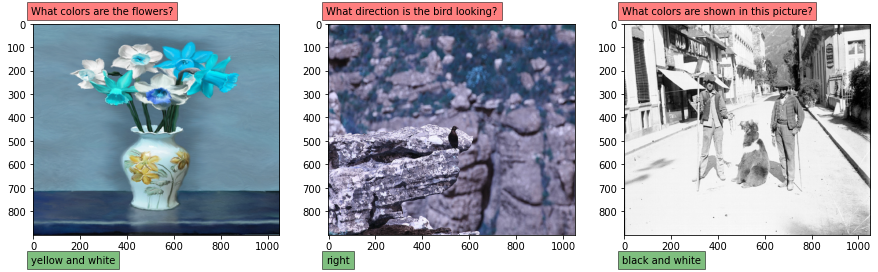


3 most frequent first words in questions:


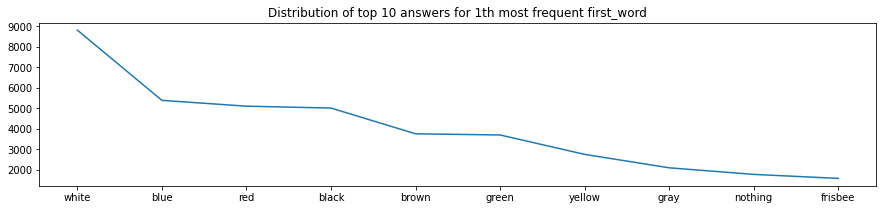

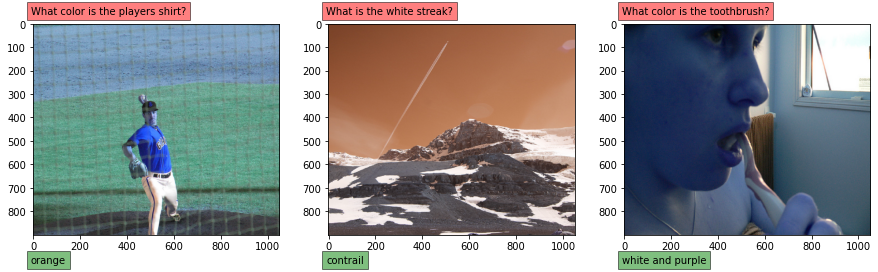

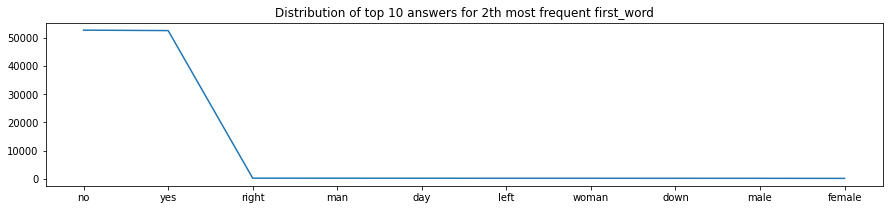

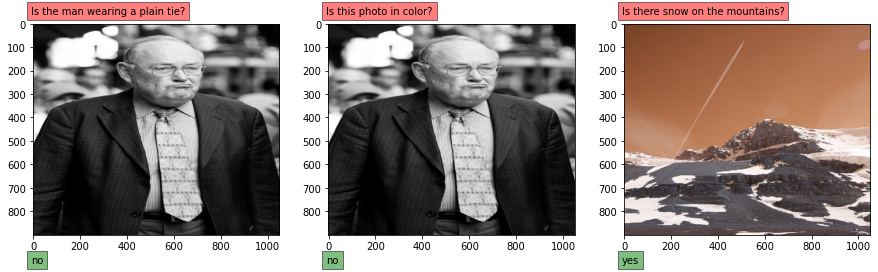

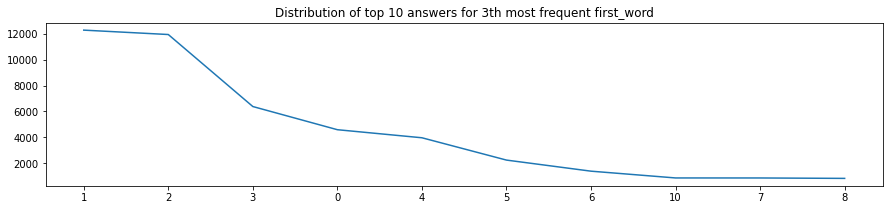

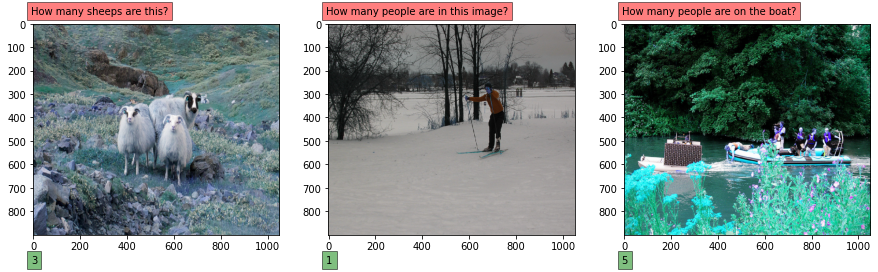


3 most frequent second words in questions:


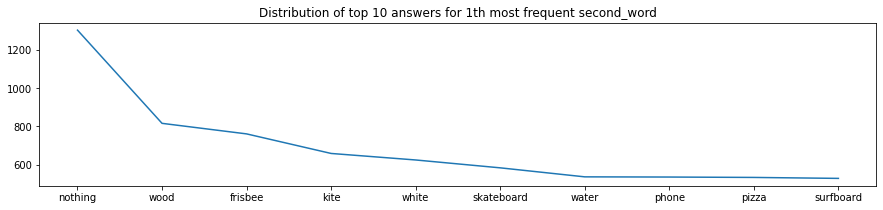

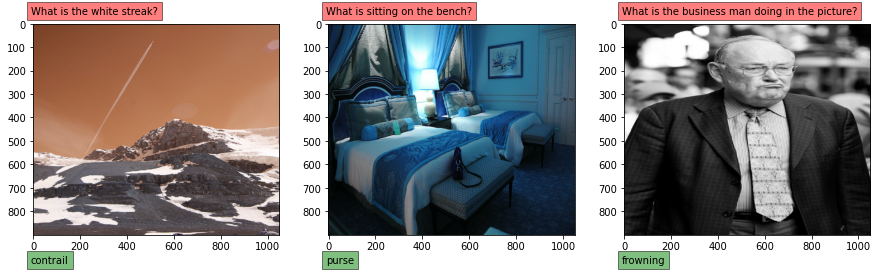

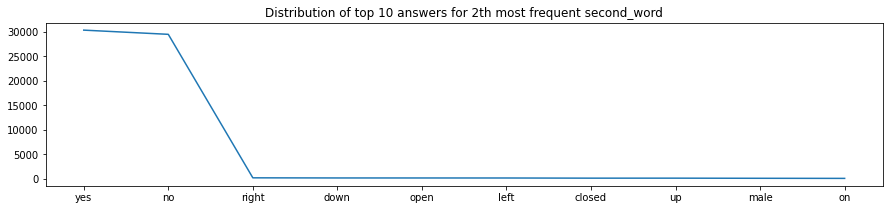

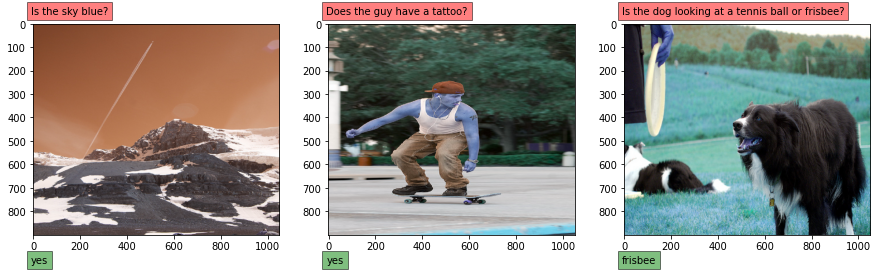

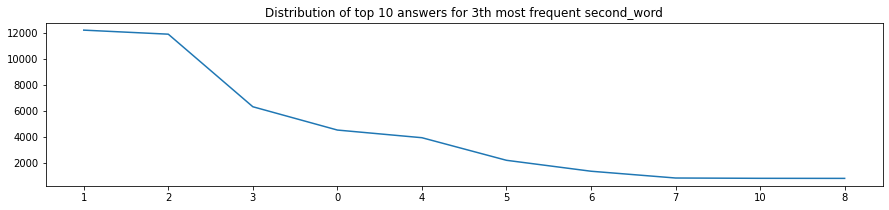

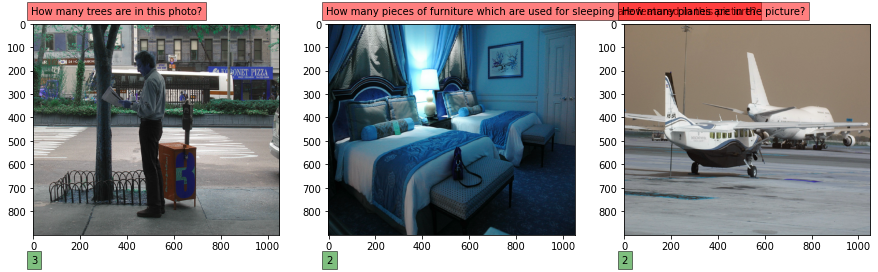

In [454]:
#9 Plotting image, question and corresponding answer for most frequent questions

# 3 most frequent questions
print(colored('\n3 most frequent questions:',attrs=['bold']))
plot_3_most_repeated(df_,'question')
# 3 most frequent question types
print(colored('\n3 most frequent question types:',attrs=['bold']))
plot_3_most_repeated(df_,'question_type')
# 3 most frequent first words in questions
print(colored('\n3 most frequent first words in questions:',attrs=['bold']))
plot_3_most_repeated(df_,'first_word')
# 3 most frequent second words in questions
print(colored('\n3 most frequent second words in questions:',attrs=['bold']))
plot_3_most_repeated(df_,'second_word')


# Observations:
1) Most frequent answer for the most freq question "What room is this" is: bathroom, followed by kitchen

2) 2nd most frequent question is "What is the man doing?". Most frequent answers are skateboarding and surfing respectively

3) 3rd most frequent question is "What sport is this?". Most frequent answers are baseball and tennis respectively.

4) For most frequent question type "How many", most frequent answers are 1 and 2.

5) For 2nd most frequent question type "Is the", most frequent answers are yes and no

6) For 3rd most frequent question type "What", answers vary lot more.

7) For questions starting with "What", most frequent answers are a color. For questions starting with "Is", most frequent answers are Yes and No. For questions starting with "How", most frequent answers are numbers.

8) For questions having second word as "the", the most frequent answers are yes and no. For questions having second word as "many", the most frequent answers are numericals

In [484]:
#10 Exploring question-answer pairs where answers is a subset of the question
answer_lies_in_question(df_[['question','multiple_choice_answer','question_type','answer_type']])


Number of Questions where answer lies in the question:
7774

Frequency of Questions where the answer lies in the question itself:
Overcast or sunny?                                        92
Is it day or night?                                       87
Sunny or overcast?                                        57
Is this a man or a woman?                                 43
Is it daytime or nighttime?                               38
                                                          ..
Is the person on a snowboard or skis?                      1
Is this an ocean or a river?                               1
Is there a black pen in no the desk?                       1
Is the top cabinet open or shut?                           1
Is this person attempting a stunt or are they falling?     1
Name: question, Length: 4974, dtype: int64

Frequency of Question types where the answer lies in the question itself:
is the                      1935
is this a                    833
is this       

# Observations:
1) 7774 questions have answers as a subset of questions

2) Most frequent such question is "Overcast or sunny?"

3) Most frequent such question types are "is the" , "is it" etc.

4) Most frequent such answers are: 'many', 'man', 'right', 'left' etc

5) Most frequent such answer types are: 'other' and numerical 


3 most frequent answers:


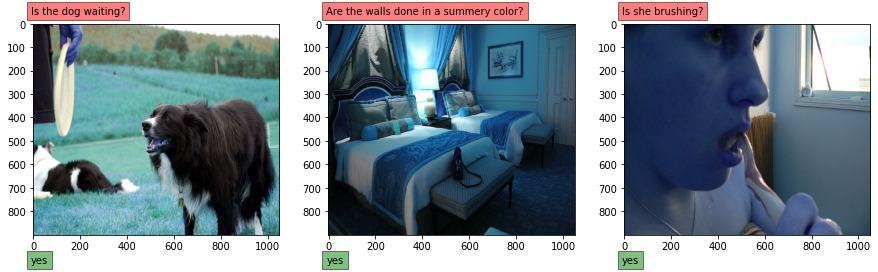

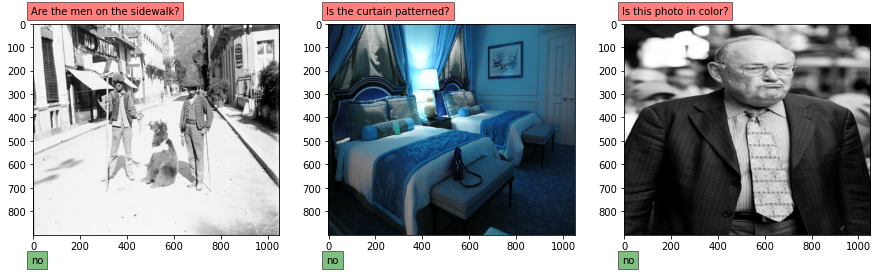

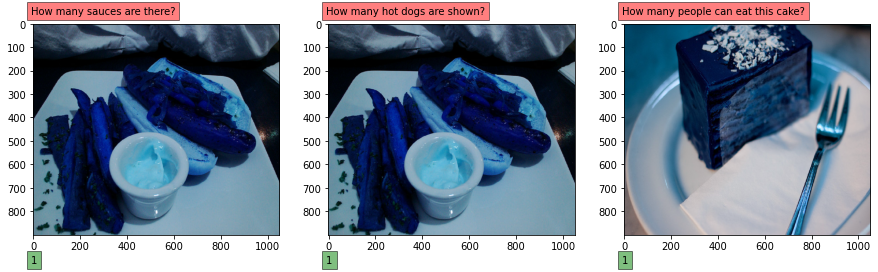


3 most frequent answers types:


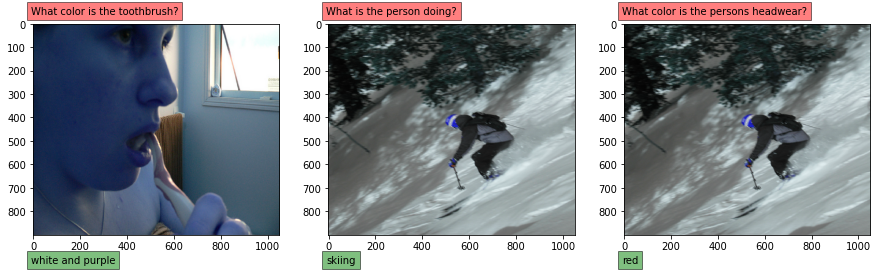

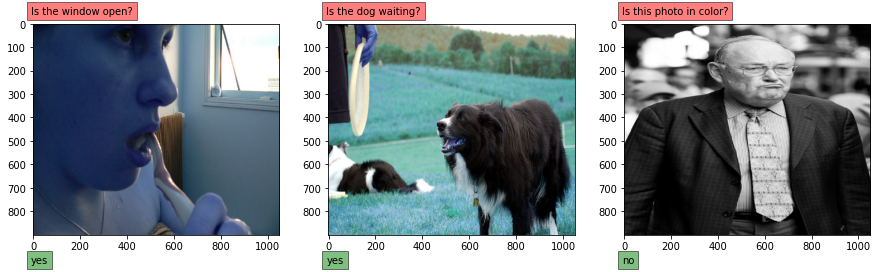

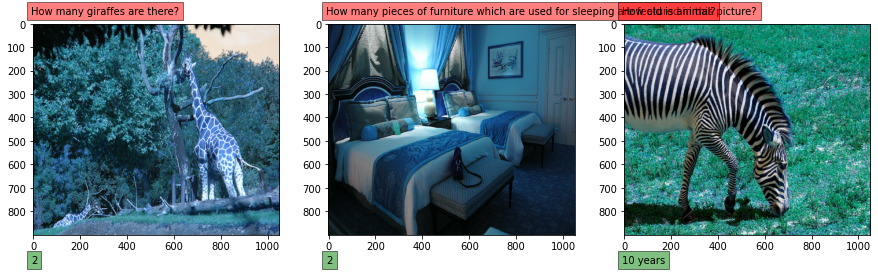

In [486]:
#11 Plotting image, question and corresponding answer for most frequent answers and answer types

# 3 most frequent answers
print(colored('\n3 most frequent answers:',attrs=['bold']))
plot_3_most_repeated(df_,'multiple_choice_answer')
# 3 most frequent question types
print(colored('\n3 most frequent answers types:',attrs=['bold']))
plot_3_most_repeated(df_,'answer_type')

# Observations:
1) Most frequent question type for the most freq answers i.e. Yes, No are: Is it, Are they, How many..

2) Most frequent answer type is others, for which the questions are quite varied.

3) Next most frequent answer types are yes, no and numerical count based questions.